# How Bad Is Your Colormap?

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

**(Or, Why People Hate Jet – and You Should Too)**

I made a little code snippet that I find helpful, and you might too:

In [1]:
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

What this function does is to give you a *lumninance-correct* grayscale version of any matplotlib colormap.
I've found this useful for quickly checking how my plots might appear if printed in black and white, but I think it's probably even more useful for stoking the flame of the internet's general rant against *jet*.

<!-- PELICAN_END_SUMMARY -->

If you want to take a step toward joining the in-crowd of chromatically-sensitive data viz geeks, your best bet is to start by bashing *jet*. Even if you don't know it by name, I can guarantee that if you've read many scientific papers, you've seen jet before. For example, here's a snapshot of a plot from neuroscience journal which is skewered by an [appropriately ranty blogpost](https://abandonmatlab.wordpress.com/2011/05/07/lets-talk-colormaps/) on the subject:

<img src="http://jakevdp.github.io/figures/jet.png">

Jet is the default colorbar originally used by matlab, and this default was inherited in the early days of Python's ``matplotlib`` package. The reasons not to use jet are numerous, and you can find good arguments against it across the web. For some more subdued and nuanced arguments, I'd start with the paper [Rainbow Color Map (Still) Considered Harmful](http://www.jwave.vt.edu/~rkriz/Projects/create_color_table/color_07.pdf) and, for more general visualization tips, [Ten Simple Rules for Better Figures](http://www.ploscompbiol.org/article/info%3Adoi%2F10.1371%2Fjournal.pcbi.1003833).

So what do I have to add to this discussion that hasn't been already said? Well, nothing really, except the code snippet I shared above. Let me show you what it does.

## Taking the Color Out of Jet

Let's start by defining some data and seeing how it looks with the default ``jet`` colormap:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 6)
y = np.linspace(0, 3)[:, np.newaxis]
z = 10 * np.cos(x ** 2) * np.exp(-y)

We'll use matplotlib's ``imshow`` command to visualize this.
By default, it will use the ``"jet"`` colormap:

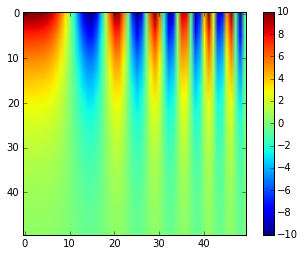

In [4]:
plt.imshow(z)
plt.colorbar();

At first glance this might look OK. But upon closer examination, you might notice that jet's *Luminance profile* is incredibly complicated.
Because your eye has different levels of sensitivity to light of different color, the luminance is not simply the sum of the RGB values as you might naively expect, but some weighted Euclidean sum of the individual values. You can find more information than you'd ever need to know on [imagemagick's website](http://www.imagemagick.org/Usage/color_mods/#grayscale).

When you take the jet colormap used above and convert it to luminance using the code snippet above, you get this:

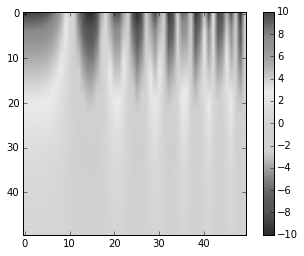

In [5]:
plt.imshow(z, cmap=grayify_cmap('jet'))
plt.colorbar();

It's a mess! The greyscale-only version of this colormap has strange luminance spikes in the middle, and makes it incredibly difficult to figure out what's going on in a plot with a modicum of complexity. Much better is to use a colormap with a uniform luminance gradient, such as the built-in grayscale colormap. Let's plot this beside the previous two:

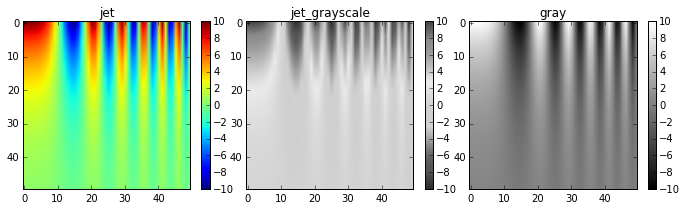

In [6]:
cmaps = [plt.cm.jet, grayify_cmap('jet'), plt.cm.gray]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.subplots_adjust(wspace=0)

for cmap, ax in zip(cmaps, axes):
    im = ax.imshow(z, cmap=cmap)
    ax.set_title(cmap.name)
    fig.colorbar(im, ax=ax)

In particular, notice that in the left panel, your eye is drawn to the yellow and cyan regions, because the luminance is higher. This can have the unfortunate side-effect of highlighting "features" in your data which may not actually exist!

We can see this Luminance spike more clearly if we look at the color profile of jet up close:

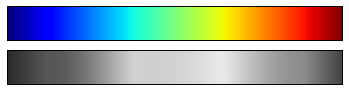

In [7]:
def show_colormap(cmap):
    im = np.outer(np.ones(10), np.arange(100))
    fig, ax = plt.subplots(2, figsize=(6, 1.5),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1)
    ax[0].imshow(im, cmap=cmap)
    ax[1].imshow(im, cmap=grayify_cmap(cmap))
    
show_colormap('jet')

Once you have the grayscale lined-up with the color version, it's easy to point out these luminance spikes in the jet spectrum. By comparison, take a look at the [Cube Helix colormap](https://www.mrao.cam.ac.uk/~dag/CUBEHELIX/):

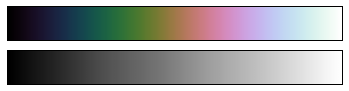

In [8]:
show_colormap('cubehelix')

This is a rainbow-like colormap which – by design – has a uniform luminance gradient across its progression of colors. It's certainly not the best choice in all situations, but you could easily argue that it's always a better choice than jet.

## All the Colormaps!

It's useful to see this sort of visualization for all the available colormaps in matplotlib. Here's a quick script that does this:

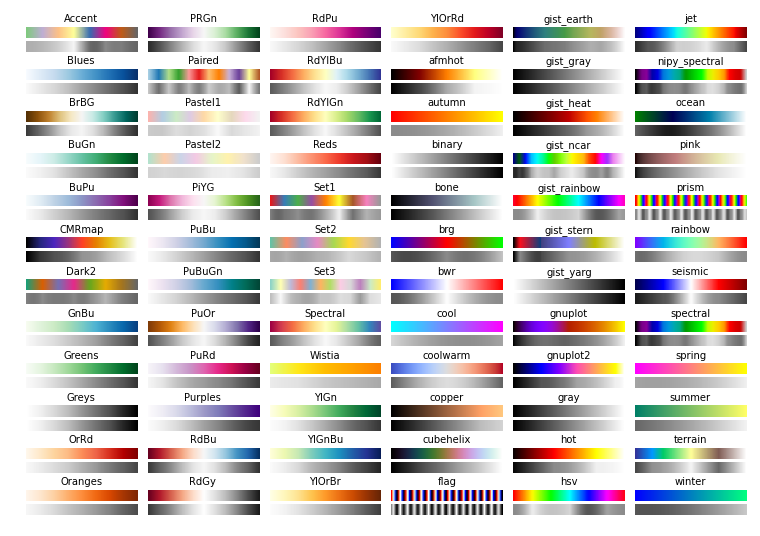

In [18]:
fig, axes = plt.subplots(36, 6, figsize=(10, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1,
                    hspace=0.1, wspace=0.1)

im = np.outer(np.ones(10), np.arange(100))

cmaps = [m for m in plt.cm.datad if not m.endswith("_r")]
cmaps.sort()

axes = axes.T.ravel()
for ax in axes:
    ax.axis('off')

for cmap, color_ax, gray_ax, null_ax in zip(cmaps, axes[1::3], axes[2::3], axes[::3]):
    del null_ax
    color_ax.set_title(cmap, fontsize=10)
    color_ax.imshow(im, cmap=cmap)
    gray_ax.imshow(im, cmap=grayify_cmap(cmap))

There are some colormaps in here that have very nice, linear luminance gradients, and this is something you should keep in mind when choosing your color map.

Much more could be written about choosing an appropriate color map for any given data; for a more in-depth discussion of matplotlib's maps (and some interesting luminance illustrations), you can refer to matplotlib's [choosing a colormap](http://matplotlib.org/users/colormaps.html) documentation.

If you're interested in streamlined statistical plotting in Python with well thought-out default color choices, I'd suggest taking a look at Michael Waskom's [seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/) project, and especially the associated [Color Palette Tutorial](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html).

I hope you find this ``grayify_cmap`` snippet helpful, and thanks for reading!

*This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/HowBadIsYourColormap.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/HowBadIsYourColormap.ipynb).*